In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 500 images
cnv_subset = cnv.sample(n=100,random_state=42)
normal_subset = normal.sample(n=100,random_state=42)
drusen_subset = drusen.sample(n=100,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)


In [ ]:
len(sampled_data)

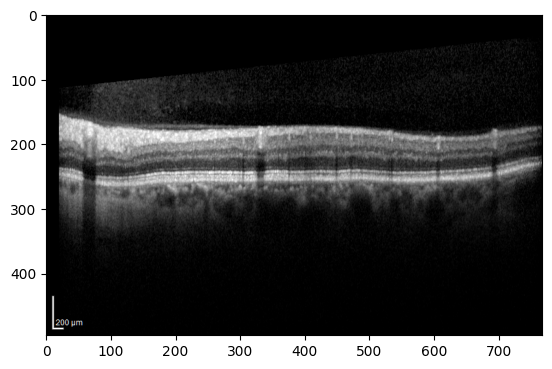

In [ ]:
import cv2
images=[]
for i in cnv['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

# **deep learning**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Load and preprocess images
images = [cv2.imread(os.path.join(data_dir, f)) for f in sampled_data['Directory']]
images = np.array([cv2.resize(img, (128, 128)) for img in images if img is not None])
images = images.astype('float32') / 255.0  # Normalize to 0-1 range

labels = pd.get_dummies(sampled_data['Label']).values

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(labels[0]), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1
losses = []
accuracies = []


for train_index, val_index in kf.split(images):
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create a new model for each fold
    model = create_model()

    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Saving losses and accuracies for analysis
    losses.append(history.history['val_loss'])
    accuracies.append(history.history['val_accuracy'])

    fold_no += 1

# Optionally, average your evaluation metrics across folds
average_accuracy = np.mean(accuracies, axis=0)
average_loss = np.mean(losses, axis=0)
print(f'Average Accuracy: {average_accuracy[-1]}')
print(f'Average Loss: {average_loss[-1]}')

Training on fold 1...
Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 1.3505 - accuracy: 0.3500 - val_loss: 1.0924 - val_accuracy: 0.4000
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.0613 - accuracy: 0.4583 - val_loss: 1.1048 - val_accuracy: 0.3500
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 0.9959 - accuracy: 0.5292 - val_loss: 1.0337 - val_accuracy: 0.5667
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.8740 - accuracy: 0.6083 - val_loss: 1.0144 - val_accuracy: 0.5500
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.8144 - accuracy: 0.6250 - val_loss: 1.0107 - val_accuracy: 0.5333
Epoch 6/10
8/8 [==============================] - 9s 1s/step - loss: 0.7265 - accuracy: 0.7333 - val_loss: 1.0819 - val_accuracy: 0.5667
Epoch 7/10
8/8 [==============================] - 19s 2s/step - loss: 0.6568 - accuracy: 0.6917 - val_loss: 1.1468 - val_accuracy: 0.5167
Epoch 8/10
8/8

In [ ]:
# Function to compute evaluation metrics
def evaluate_model(model, X, y_true):
    # Predict probabilities
    y_pred_proba = model.predict(X)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_true, axis=1)

    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute ROC AUC score
    roc_auc = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovo')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return precision, recall, f1, roc_auc, cm


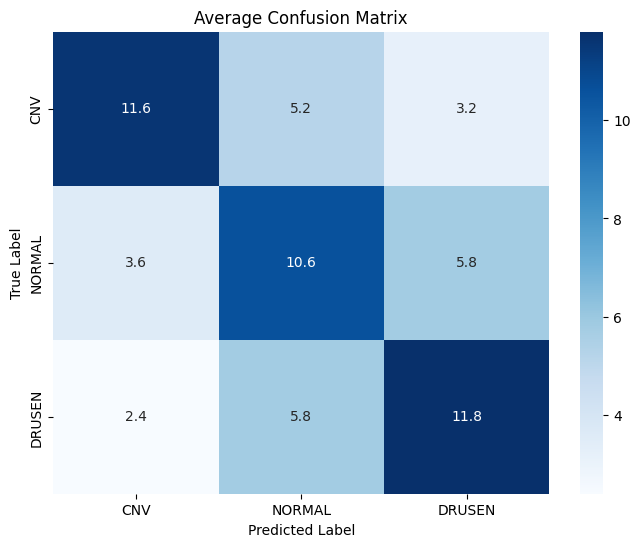

In [ ]:
# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['CNV', 'NORMAL', 'DRUSEN'], yticklabels=['CNV', 'NORMAL', 'DRUSEN'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix')
plt.show()


In [ ]:
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average ROC AUC: {avg_roc_auc}')
# Calculate average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Print average confusion matrix
print("Average Confusion Matrix:")
print(avg_confusion_matrix)

Average Precision: 0.5912882696938425
Average Recall: 0.5833333333333334
Average F1 Score: 0.5853505679592637
Average ROC AUC: 0.7652968532461624
Average Confusion Matrix:
[[11.6  5.2  3.2]
 [ 3.6 10.6  5.8]
 [ 2.4  5.8 11.8]]


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model



# Function to preprocess images
def preprocess_images(images):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (224, 224))
        resized_images.append(resized_img)
    return np.array(resized_images)

# Function to make predictions
def make_predictions(images, model):
    preprocessed_images = preprocess_images(images)
    predictions = model.predict(preprocessed_images)
    return predictions

# Example usage
unseen_data_dir = '/content/drive/MyDrive/TST'  # Update with the path to your unseen data directory
unseen_images = []

# Read unseen images
for filename in os.listdir(unseen_data_dir):
    img = cv2.imread(os.path.join(unseen_data_dir, filename))
    if img is not None:
        unseen_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Make predictions
predictions = make_predictions(unseen_images, model)

# Display predictions
for i, pred in enumerate(predictions):
    print(f'Image {i+1} - Predicted probabilities: {pred}')


1/1 [==============================] - 2s 2s/step
Image 1 - Predicted probabilities: [0.7476921 0.2523079]
Image 2 - Predicted probabilities: [0.89191777 0.1080822 ]
Image 3 - Predicted probabilities: [0.9982442  0.00175569]
Image 4 - Predicted probabilities: [0.48429868 0.51570135]
Image 5 - Predicted probabilities: [0.9943276  0.00567239]
Image 6 - Predicted probabilities: [0.57151455 0.42848545]
Image 7 - Predicted probabilities: [0.9182209  0.08177914]
Image 8 - Predicted probabilities: [0.99829555 0.00170444]
Image 9 - Predicted probabilities: [0.995424   0.00457608]
Image 10 - Predicted probabilities: [0.9756669  0.02433303]
Image 11 - Predicted probabilities: [0.9958724  0.00412763]
Image 12 - Predicted probabilities: [0.6543302 0.3456698]
Image 13 - Predicted probabilities: [0.997851   0.00214902]
Image 14 - Predicted probabilities: [0.99738616 0.00261383]
Image 15 - Predicted probabilities: [0.97276986 0.02723012]
Image 16 - Predicted probabilities: [0.9911092  0.00889089]
Ima

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

# Function to preprocess images
def preprocess_images(images):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (224, 224))
        resized_images.append(resized_img)
    return np.array(resized_images)

# Function to make predictions
def make_predictions(images, model):
    preprocessed_images = preprocess_images(images)
    predictions = model.predict(preprocessed_images)
    return predictions

# Example usage
unseen_data_dir = '/content/drive/MyDrive/TST'  # Update with the path to your unseen data directory
unseen_images = []

# Read unseen images
for filename in os.listdir(unseen_data_dir):
    img = cv2.imread(os.path.join(unseen_data_dir, filename))
    if img is not None:
        unseen_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Make predictions and output the results
print("File Name\t\t\t\tPrediction")
print("-----------------------------------------------")
for i, (img, pred) in enumerate(zip(unseen_images, make_predictions(unseen_images, model))):
    print(f"{os.path.basename(os.listdir(unseen_data_dir)[i])}\t\t\t{pred}")


File Name				Prediction
-----------------------------------------------
1/1 [==============================] - 1s 1s/step
Copy of 007_Drusen.tif			[0.7476921 0.2523079]
Copy of 002_Normal.tif			[0.89191777 0.1080822 ]
Copy of 014_CNV.tif			[0.9982442  0.00175569]
Copy of 000_Normal.tif			[0.48429868 0.51570135]
Copy of 010_CNV.tif			[0.9943276  0.00567239]
Copy of 003_Normal.tif			[0.57151455 0.42848545]
Copy of 006_Normal.tif			[0.9182209  0.08177914]
Copy of 012_CNV.tif			[0.99829555 0.00170444]
Copy of 011_CNV.tif			[0.995424   0.00457608]
Copy of 009_CNV.tif			[0.9756669  0.02433303]
Copy of 021_CNV.tif			[0.9958724  0.00412763]
Copy of 001_Normal.tif			[0.6543302 0.3456698]
Copy of 019_CNV.tif			[0.997851   0.00214902]
Copy of 020_CNV.tif			[0.99738616 0.00261383]
Copy of 008_Drusen.tif			[0.97276986 0.02723012]
Copy of 017_CNV.tif			[0.9911092  0.00889089]
Copy of 027_Drusen.tif			[0.63774025 0.3622598 ]
Copy of 004_Normal.tif			[0.726239  0.2737609]
Copy of 005_Normal.tif			[0.8

# **hog**

In [ ]:
from skimage.feature import hog
from skimage import exposure
import cv2
from skimage.filters import threshold_otsu


# Function to extract HOG features
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(threshold_image if do_otsu else gray_image,
                                  visualize=True, multichannel=False,
                                  pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images

# Define the directory containing the images
images_dir = '/content/drive/MyDrive/Eye/'  # Update with the directory containing your images

# Load images from sampled_data and extract HOG features
gray_images = []
for index, row in sampled_data.iterrows():
    img_path = os.path.join(images_dir, row['Directory'])
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        continue
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

# Extract HOG features
hog_features, hog_images, _ = extract_hog_features(gray_images)


<ipython-input-5-8a73f093c2de>:19: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(threshold_image if do_otsu else gray_image,


In [ ]:
print("Shape of HOG features:", hog_features.shape)


Shape of HOG features: (300, 208620)


Training on fold 1...
Epoch 1/10
8/8 [==============================] - 10s 888ms/step - loss: 3.0078 - accuracy: 0.3708 - val_loss: 1.9662 - val_accuracy: 0.3667
Epoch 2/10
8/8 [==============================] - 4s 516ms/step - loss: 1.0333 - accuracy: 0.6208 - val_loss: 1.2888 - val_accuracy: 0.4333
Epoch 3/10
8/8 [==============================] - 5s 577ms/step - loss: 0.7580 - accuracy: 0.6792 - val_loss: 1.0830 - val_accuracy: 0.3833
Epoch 4/10
8/8 [==============================] - 6s 728ms/step - loss: 0.6434 - accuracy: 0.7458 - val_loss: 1.1092 - val_accuracy: 0.4333
Epoch 5/10
8/8 [==============================] - 4s 500ms/step - loss: 0.4808 - accuracy: 0.8083 - val_loss: 1.1162 - val_accuracy: 0.4333
Epoch 6/10
8/8 [==============================] - 4s 506ms/step - loss: 0.4204 - accuracy: 0.8167 - val_loss: 1.3324 - val_accuracy: 0.4000
Epoch 7/10
8/8 [==============================] - 6s 755ms/step - loss: 0.3313 - accuracy: 0.8667 - val_loss: 1.2288 - val_accuracy: 0.43

2/2 [==============================] - 0s 39ms/step
Average Precision: 0.5463900120135818
Average Recall: 0.531499254905052
Average F1 Score: 0.5101169080431227
Average ROC AUC: 0.7084768358733342


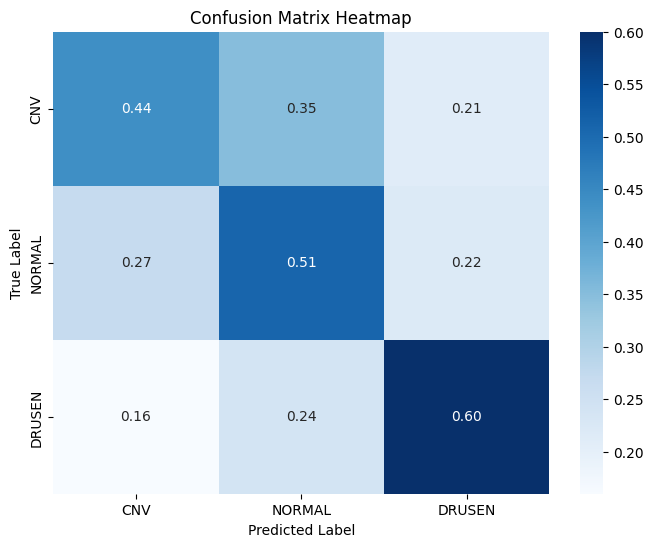

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(len(labels[0]), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Define a function to evaluate the model and generate evaluation metrics
def evaluate_model(model, X, y_true):
    y_pred_proba = model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)
    precision = precision_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    recall = recall_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)
    return precision, recall, f1, roc_auc, cm

# Define a function to plot the confusion matrix heatmap
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix Heatmap', cmap=None, normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f" if normalize else "d", xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Initialize lists to store evaluation metrics across folds
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
confusion_matrices = []

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1

# Iterate over folds
for train_index, val_index in kf.split(hog_features):
    X_train, X_val = hog_features[train_index], hog_features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create a new model for each fold
    model = create_model(input_shape=(X_train.shape[1],))

    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    precision, recall, f1, roc_auc, cm = evaluate_model(model, X_val, y_val)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    confusion_matrices.append(cm)

    fold_no += 1

# Optionally, average your evaluation metrics across folds
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)
average_roc_auc = np.mean(roc_aucs)

print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')
print(f'Average ROC AUC: {average_roc_auc}')

# Plot the average confusion matrix heatmap
average_cm = np.mean(confusion_matrices, axis=0)
plot_confusion_matrix(average_cm, target_names=['CNV', 'NORMAL', 'DRUSEN'])


# **LBP**

LBP features shape: (300, 9)
Sample LBP features:
[[0.04739478 0.06997385 0.05467175 0.08413138 0.08808226 0.0647734
  0.04544428 0.04187405 0.50365423]
 [0.05723654 0.09149761 0.05045573 0.0714387  0.07387485 0.054677
  0.03852959 0.04132014 0.52096984]
 [0.03637958 0.05396033 0.04727403 0.07894143 0.08498719 0.06529055
  0.04597719 0.04273248 0.54445722]
 [0.04700626 0.06887391 0.05976195 0.10086683 0.10247081 0.07572822
  0.05378969 0.0479697  0.44353264]
 [0.05334604 0.08004662 0.0652013  0.10761876 0.11109974 0.08427052
  0.05899278 0.05584782 0.38357642]]
Training on fold 1...
Epoch 1/10
8/8 [==============================] - 1s 30ms/step - loss: 1.1022 - accuracy: 0.3417 - val_loss: 1.1032 - val_accuracy: 0.3667
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 1.1007 - accuracy: 0.3292 - val_loss: 1.1029 - val_accuracy: 0.3167
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 1.1022 - accuracy: 0.3417 - val_loss: 1.1019 - val_accuracy: 0.

2/2 [==============================] - 0s 7ms/step
Training on fold 2...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 32ms/step - loss: 1.1062 - accuracy: 0.3208 - val_loss: 1.0973 - val_accuracy: 0.3667
Epoch 2/10
8/8 [==============================] - 0s 9ms/step - loss: 1.1118 - accuracy: 0.3083 - val_loss: 1.0987 - val_accuracy: 0.3667
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0949 - accuracy: 0.3042 - val_loss: 1.1010 - val_accuracy: 0.3167
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0998 - accuracy: 0.3417 - val_loss: 1.1027 - val_accuracy: 0.2000
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 1.0948 - accuracy: 0.3500 - val_loss: 1.1052 - val_accuracy: 0.2333
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0958 - accuracy: 0.3500 - val_loss: 1.1044 - val_accuracy: 0.2333
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 1.0989 - accuracy: 0.3583 - val_loss: 1.1065 - val_accuracy: 0.2500
Epoch 8/10
8/8 [============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 32ms/step - loss: 1.1059 - accuracy: 0.2875 - val_loss: 1.1016 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0951 - accuracy: 0.3958 - val_loss: 1.1033 - val_accuracy: 0.3000
Epoch 3/10
8/8 [==============================] - 0s 9ms/step - loss: 1.0981 - accuracy: 0.3167 - val_loss: 1.1080 - val_accuracy: 0.2833
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 1.0946 - accuracy: 0.3625 - val_loss: 1.1103 - val_accuracy: 0.3333
Epoch 5/10
8/8 [==============================] - 0s 9ms/step - loss: 1.1012 - accuracy: 0.3625 - val_loss: 1.1111 - val_accuracy: 0.3333
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 1.1000 - accuracy: 0.3708 - val_loss: 1.1115 - val_accuracy: 0.3333
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 1.0958 - accuracy: 0.3875 - val_loss: 1.1121 - val_accuracy: 0.3333
Epoch 8/10
8/8 [============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 34ms/step - loss: 1.1119 - accuracy: 0.2875 - val_loss: 1.0950 - val_accuracy: 0.4500
Epoch 2/10
8/8 [==============================] - 0s 9ms/step - loss: 1.0989 - accuracy: 0.3417 - val_loss: 1.1015 - val_accuracy: 0.2333
Epoch 3/10
8/8 [==============================] - 0s 9ms/step - loss: 1.0968 - accuracy: 0.3792 - val_loss: 1.1057 - val_accuracy: 0.2333
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 1.0966 - accuracy: 0.3750 - val_loss: 1.1101 - val_accuracy: 0.2333
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 1.0965 - accuracy: 0.3667 - val_loss: 1.1140 - val_accuracy: 0.2333
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0947 - accuracy: 0.3708 - val_loss: 1.1139 - val_accuracy: 0.2333
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 1.0970 - accuracy: 0.3500 - val_loss: 1.1136 - val_accuracy: 0.2333
Epoch 8/10
8/8 [===========================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 45ms/step - loss: 1.1042 - accuracy: 0.3167 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 0s 9ms/step - loss: 1.1013 - accuracy: 0.3167 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 3/10
8/8 [==============================] - 0s 13ms/step - loss: 1.1039 - accuracy: 0.2917 - val_loss: 1.0997 - val_accuracy: 0.3333
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 1.0944 - accuracy: 0.3500 - val_loss: 1.0997 - val_accuracy: 0.3833
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 1.0991 - accuracy: 0.3417 - val_loss: 1.1003 - val_accuracy: 0.3667
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 1.1011 - accuracy: 0.3125 - val_loss: 1.1002 - val_accuracy: 0.3167
Epoch 7/10
8/8 [==============================] - 0s 11ms/step - loss: 1.1006 - accuracy: 0.3167 - val_loss: 1.1003 - val_accuracy: 0.3000
Epoch 8/10
8/8 [========================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


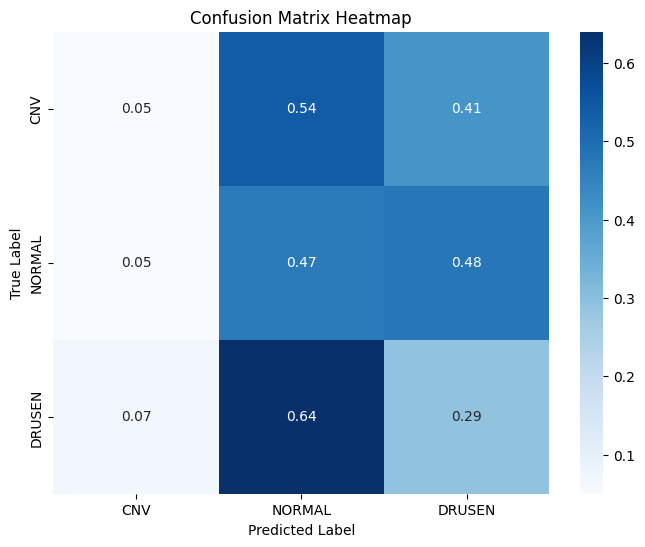

In [ ]:
import cv2
import numpy as np
from skimage import feature

# List to store LBP features
lbp_features = []

# Iterate through sampled_data DataFrame
for index, row in sampled_data.iterrows():
    img_path = os.path.join(data_dir, row['Directory'])
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        continue

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute LBP features
    lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Append LBP features to the list
    lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)

# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])


# Initialize lists to store evaluation metrics across folds
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
confusion_matrices = []

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1

# Define a function to create the model
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(len(labels[0]), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over folds
for train_index, val_index in kf.split(lbp_features):
    X_train, X_val = lbp_features[train_index], lbp_features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create a new model for each fold
    model = create_model(input_shape=(X_train.shape[1],))

    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    precision, recall, f1, roc_auc, cm = evaluate_model(model, X_val, y_val)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    confusion_matrices.append(cm)

    fold_no += 1

# Optionally, average your evaluation metrics across folds
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)
average_roc_auc = np.mean(roc_aucs)

print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')
print(f'Average ROC AUC: {average_roc_auc}')

# Plot the average confusion matrix heatmap
average_cm = np.mean(confusion_matrices, axis=0)
plot_confusion_matrix(average_cm, target_names=['CNV', 'NORMAL', 'DRUSEN'])

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

Training on fold 1...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

8/8 [==============================] - 1s 63ms/step - loss: 24.3947 - accuracy: 0.2750 - val_loss: 5.0866 - val_accuracy: 0.3667
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 20.7654 - accuracy: 0.3708 - val_loss: 3.7109 - val_accuracy: 0.3667
Epoch 3/10
8/8 [==============================] - 0s 15ms/step - loss: 24.6928 - accuracy: 0.3083 - val_loss: 2.8042 - val_accuracy: 0.3667
Epoch 4/10
8/8 [==============================] - 0s 16ms/step - loss: 20.7256 - accuracy: 0.2958 - val_loss: 4.1205 - val_accuracy: 0.3667
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 19.8536 - accuracy: 0.3333 - val_loss: 2.5896 - val_accuracy: 0.3667
Epoch 6/10
8/8 [==============================] - 0s 18ms/step - loss: 19.4889 - accuracy: 0.3125 - val_loss: 1.8404 - val_accuracy: 0.2833
Epoch 7/10
8/8 [==============================] - 0s 14ms/step - loss: 18.0369 - accuracy: 0.3042 - val_loss: 2.2599 - val_accuracy: 0.3667
Epoch 8/10
8/8 [===============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
8/8 [==============================] - 3s 57ms/step - loss: 28.2963 - accuracy: 0.3167 - val_loss: 9.0524 - val_accuracy: 0.3833
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 25.1487 - accuracy: 0.3208 - val_loss: 3.1809 - val_accuracy: 0.3833
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 18.0349 - accuracy: 0.3542 - val_loss: 4.7598 - val_accuracy: 0.2500
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 19.9687 - accuracy: 0.3250 - val_loss: 7.5049 - val_accuracy: 0.2500
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 20.1132 - accuracy: 0.2792 - val_loss: 6.5122 - val_accuracy: 0.2500
Epoch 6/10
8/8 [==============================] - 0s 15ms/step - loss: 20.6004 - accuracy: 0.2750 - val_loss: 2.5620 - val_accuracy: 0.2500
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 14.9723 - accuracy: 0.3000 - val_loss: 1.1862 - val_accuracy: 0.2833
Epoch 8/10
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
8/8 [==============================] - 2s 118ms/step - loss: 24.1174 - accuracy: 0.3250 - val_loss: 13.6437 - val_accuracy: 0.3000
Epoch 2/10
8/8 [==============================] - 0s 28ms/step - loss: 20.1581 - accuracy: 0.3250 - val_loss: 3.1050 - val_accuracy: 0.4333
Epoch 3/10
8/8 [==============================] - 0s 32ms/step - loss: 19.3965 - accuracy: 0.3542 - val_loss: 5.7489 - val_accuracy: 0.4333
Epoch 4/10
8/8 [==============================] - 0s 23ms/step - loss: 22.5568 - accuracy: 0.3333 - val_loss: 2.5876 - val_accuracy: 0.4333
Epoch 5/10
8/8 [==============================] - 0s 18ms/step - loss: 18.7806 - accuracy: 0.3542 - val_loss: 2.4366 - val_accuracy: 0.3667
Epoch 6/10
8/8 [==============================] - 0s 24ms/step - loss: 19.6888 - accuracy: 0.2500 - val_loss: 3.0178 - val_accuracy: 0.4333
Epoch 7/10
8/8 [==============================] - 0s 19ms/step - loss: 20.2648 - accuracy: 0.3125 - val_loss: 3.7748 - val_accuracy: 0.4333
Epoch 8/10
8/8 [==

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on fold 4...
Epoch 1/10
8/8 [==============================] - 2s 61ms/step - loss: 27.6087 - accuracy: 0.3000 - val_loss: 8.3083 - val_accuracy: 0.4500
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 19.4219 - accuracy: 0.3417 - val_loss: 5.7744 - val_accuracy: 0.2167
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 17.8533 - accuracy: 0.3375 - val_loss: 7.1557 - val_accuracy: 0.2167
Epoch 4/10
8/8 [==============================] - 0s 19ms/step - loss: 18.7463 - accuracy: 0.3792 - val_loss: 4.9764 - val_accuracy: 0.3333
Epoch 5/10
8/8 [==============================] - 0s 16ms/step - loss: 16.5423 - accuracy: 0.3292 - val_loss: 3.2729 - val_accuracy: 0.3167
Epoch 6/10
8/8 [==============================] - 0s 14ms/step - loss: 12.9947 - accuracy: 0.3417 - val_loss: 1.8251 - val_accuracy: 0.3167
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 15.1595 - accuracy: 0.3167 - val_loss: 1.6994 - val_accuracy: 0.316

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 34ms/step - loss: 37.0789 - accuracy: 0.3458 - val_loss: 6.9027 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 25.7981 - accuracy: 0.3750 - val_loss: 2.2768 - val_accuracy: 0.3333
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 22.3440 - accuracy: 0.3208 - val_loss: 2.1635 - val_accuracy: 0.3667
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 24.6496 - accuracy: 0.3250 - val_loss: 2.1262 - val_accuracy: 0.3500
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 25.7629 - accuracy: 0.3292 - val_loss: 1.7360 - val_accuracy: 0.3000
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 23.0166 - accuracy: 0.3000 - val_loss: 4.0156 - val_accuracy: 0.3333
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 21.3021 - accuracy: 0.3125 - val_loss: 3.3572 - val_accuracy: 0.3333
Epoch 8/10
8/8 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


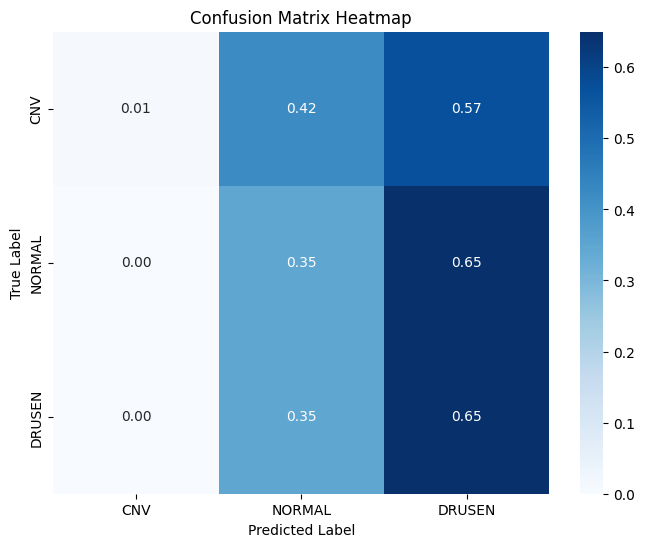

In [ ]:
import cv2
import numpy as np
import os
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Function to create the model
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 classes (CNV, NORMAL, DRUSEN)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate the model and generate evaluation metrics
def evaluate_model(model, X, y_true):
    y_pred_proba = model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)
    precision = precision_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    recall = recall_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)
    return precision, recall, f1, roc_auc, cm

# Function to plot the confusion matrix heatmap
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix Heatmap', cmap=None, normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f" if normalize else "d", xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
# List to store GLCM features
glcm_features = []

# Iterate over the rows in the 'Directory' column of sampled_data
for index, row in sampled_data.iterrows():
    # Read the image
    img_path = os.path.join(data_dir, row['Directory'])
    img = cv2.imread(img_path)

    # Check if the image was successfully loaded
    if img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        contrast = greycoprops(glcm, 'contrast')
        dissimilarity = greycoprops(glcm, 'dissimilarity')
        homogeneity = greycoprops(glcm, 'homogeneity')
        energy = greycoprops(glcm, 'energy')
        correlation = greycoprops(glcm, 'correlation')

        # Append GLCM properties to the list
        glcm_features.append([contrast[0, 0], dissimilarity[0, 0], homogeneity[0, 0], energy[0, 0], correlation[0, 0]])

# Convert the list of GLCM features to a numpy array
glcm_features = np.array(glcm_features)


# Initialize lists to store evaluation metrics across folds
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
confusion_matrices = []

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1

# Iterate over folds
for train_index, val_index in kf.split(glcm_features):
    X_train, X_val = glcm_features[train_index], glcm_features[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create a new model for each fold
    model = create_model(input_shape=(X_train.shape[1],))

    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    precision, recall, f1, roc_auc, cm = evaluate_model(model, X_val, y_val)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    confusion_matrices.append(cm)

    fold_no += 1

# Optionally, average your evaluation metrics across folds
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)
average_roc_auc = np.mean(roc_aucs)

print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')
print(f'Average ROC AUC: {average_roc_auc}')

# Plot the average confusion matrix heatmap
average_cm = np.mean(confusion_matrices, axis=0)
plot_confusion_matrix(average_cm, target_names=['CNV', 'NORMAL', 'DRUSEN'])
